In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from scipy.special import expit
import torch
from torch import nn, optim
import torch.nn.functional as F
from datasets.datasets import get_wine_dataloader, get_iris_dataloader
from sklearn.manifold import TSNE
device = torch.device("cpu")

## Wine

In [2]:
n_clusters = 3
batch_size = 89
dataloader, data_shape = get_wine_dataloader(batch_size)
N = len(dataloader) * batch_size

## Iris

In [2]:
n_clusters = 3
batch_size = 50
dataloader, data_shape = get_iris_dataloader(batch_size)
N = len(dataloader) * batch_size

In [3]:
k1 = 10
k2 = 30
latent_shape = 5

class Autoencoder(nn.Module):
    def __init__(self, n_features):
        super(Autoencoder, self).__init__()
        # Encoder Model
        self.encoder_model = nn.Sequential(
            nn.Linear(data_shape, k1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(k1),
            
            nn.Linear(k1, k2, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(k2),
            
            nn.Linear(k2, latent_shape, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(latent_shape),
            
            #nn.Linear(k3, k4, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(k4),
        )
        
        # Clustering MLP
        self.cluster_MLP = nn.Sequential(
            #nn.Linear(latent_shape, k1, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(k1),
            
            nn.Linear(latent_shape, n_clusters, bias=True),
            nn.BatchNorm1d(n_clusters)
        )
        
        # Decoder Model
        self.decoder_model = nn.Sequential(
            #nn.Linear(k4, k3, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(k3),
            
            nn.Linear(latent_shape, k2, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(k2),
            
            nn.Linear(k2, k1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(k1),
            
            nn.Linear(k1, data_shape, bias=True),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.encoder_model(x)
        x = self.decoder_model(x)
        return x

    def forward_softMin(self, x):
        x = self.encoder_model(x)
        x = self.cluster_MLP(x)
        x = F.softmin(x, dim=1)
        return x
    
    def encoder(self, x):
        x = self.encoder_model(x)
        return x
    
    def decoder(self, x):
        x = self.decoder_model(x)
        return x

autoencoder = Autoencoder(100)
autoencoder = autoencoder.to(device)

In [4]:
def soft_silhouette(X, soft_clustering, requires_distance_grad=False):
    # No grads at distances
    if requires_distance_grad: X = X.detach()
    distances = torch.cdist(X, X, p=2)
    alphas = torch.matmul(distances, soft_clustering)
    n_data, n_clusters = alphas.shape
    betas = torch.empty(alphas.shape)
    
    for i in range(n_data):
        for j in range(n_clusters):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    
    # Calculate soft silhouette
    sc = torch.div(torch.sub(betas, alphas), torch.max(alphas, betas))
    s = torch.mean(torch.sum(torch.mul(soft_clustering, sc), dim=1))

    return s

def transform_clusters_to_labels(clusters, labels):
    # Get the data clusters based on max neuron
    clusters = torch.argmax(clusters, dim=1)
    clusters = clusters.cpu().detach().numpy()

    # Find the cluster ids (labels)
    c_ids = np.unique(clusters)
    labels = labels.cpu().data.numpy()

    # Dictionary to transform cluster label to real label
    dict_clusters_to_labels = dict()
    
    # For every cluster find the most frequent data label
    for c_id in c_ids:
        indexes_of_cluster_i = np.where(c_id == clusters)
        elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
        true_label_index = np.argmax(frequency)
        true_label = elements[true_label_index]
        dict_clusters_to_labels[c_id] = true_label

    # Change the cluster labels to real labels
    for i, element in enumerate(clusters):
        clusters[i] = dict_clusters_to_labels[element]

    return clusters

In [5]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
mse = nn.MSELoss()

for epoch in range(1000):
    for batch_index, (real_data, labels) in enumerate(dataloader):
        reconstruction = autoencoder.forward(real_data)
        loss = mse(real_data, reconstruction)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: {} Rec: {:.4f} ".format(epoch, loss))

Epoch: 0 Rec: 0.1760 
Epoch: 1 Rec: 0.1423 
Epoch: 2 Rec: 0.1249 
Epoch: 3 Rec: 0.1141 
Epoch: 4 Rec: 0.1038 
Epoch: 5 Rec: 0.0955 
Epoch: 6 Rec: 0.0889 
Epoch: 7 Rec: 0.0840 
Epoch: 8 Rec: 0.0803 
Epoch: 9 Rec: 0.0737 
Epoch: 10 Rec: 0.0673 
Epoch: 11 Rec: 0.0637 
Epoch: 12 Rec: 0.0614 
Epoch: 13 Rec: 0.0590 
Epoch: 14 Rec: 0.0568 
Epoch: 15 Rec: 0.0554 
Epoch: 16 Rec: 0.0539 
Epoch: 17 Rec: 0.0526 
Epoch: 18 Rec: 0.0512 
Epoch: 19 Rec: 0.0486 
Epoch: 20 Rec: 0.0465 
Epoch: 21 Rec: 0.0440 
Epoch: 22 Rec: 0.0420 
Epoch: 23 Rec: 0.0407 
Epoch: 24 Rec: 0.0396 
Epoch: 25 Rec: 0.0381 
Epoch: 26 Rec: 0.0369 
Epoch: 27 Rec: 0.0359 
Epoch: 28 Rec: 0.0346 
Epoch: 29 Rec: 0.0331 
Epoch: 30 Rec: 0.0319 
Epoch: 31 Rec: 0.0310 
Epoch: 32 Rec: 0.0295 
Epoch: 33 Rec: 0.0275 
Epoch: 34 Rec: 0.0259 
Epoch: 35 Rec: 0.0252 
Epoch: 36 Rec: 0.0248 
Epoch: 37 Rec: 0.0320 
Epoch: 38 Rec: 0.0268 
Epoch: 39 Rec: 0.0238 
Epoch: 40 Rec: 0.0225 
Epoch: 41 Rec: 0.0217 
Epoch: 42 Rec: 0.0211 
Epoch: 43 Rec: 0.0206

Epoch: 368 Rec: 0.0071 
Epoch: 369 Rec: 0.0071 
Epoch: 370 Rec: 0.0072 
Epoch: 371 Rec: 0.0071 
Epoch: 372 Rec: 0.0070 
Epoch: 373 Rec: 0.0070 
Epoch: 374 Rec: 0.0071 
Epoch: 375 Rec: 0.0071 
Epoch: 376 Rec: 0.0070 
Epoch: 377 Rec: 0.0070 
Epoch: 378 Rec: 0.0070 
Epoch: 379 Rec: 0.0070 
Epoch: 380 Rec: 0.0070 
Epoch: 381 Rec: 0.0071 
Epoch: 382 Rec: 0.0070 
Epoch: 383 Rec: 0.0070 
Epoch: 384 Rec: 0.0070 
Epoch: 385 Rec: 0.0070 
Epoch: 386 Rec: 0.0070 
Epoch: 387 Rec: 0.0073 
Epoch: 388 Rec: 0.0080 
Epoch: 389 Rec: 0.0081 
Epoch: 390 Rec: 0.0077 
Epoch: 391 Rec: 0.0075 
Epoch: 392 Rec: 0.0075 
Epoch: 393 Rec: 0.0075 
Epoch: 394 Rec: 0.0074 
Epoch: 395 Rec: 0.0075 
Epoch: 396 Rec: 0.0073 
Epoch: 397 Rec: 0.0073 
Epoch: 398 Rec: 0.0073 
Epoch: 399 Rec: 0.0072 
Epoch: 400 Rec: 0.0071 
Epoch: 401 Rec: 0.0071 
Epoch: 402 Rec: 0.0071 
Epoch: 403 Rec: 0.0071 
Epoch: 404 Rec: 0.0070 
Epoch: 405 Rec: 0.0069 
Epoch: 406 Rec: 0.0069 
Epoch: 407 Rec: 0.0069 
Epoch: 408 Rec: 0.0069 
Epoch: 409 Rec: 

Epoch: 724 Rec: 0.0061 
Epoch: 725 Rec: 0.0061 
Epoch: 726 Rec: 0.0061 
Epoch: 727 Rec: 0.0060 
Epoch: 728 Rec: 0.0060 
Epoch: 729 Rec: 0.0060 
Epoch: 730 Rec: 0.0061 
Epoch: 731 Rec: 0.0061 
Epoch: 732 Rec: 0.0060 
Epoch: 733 Rec: 0.0060 
Epoch: 734 Rec: 0.0061 
Epoch: 735 Rec: 0.0060 
Epoch: 736 Rec: 0.0060 
Epoch: 737 Rec: 0.0060 
Epoch: 738 Rec: 0.0060 
Epoch: 739 Rec: 0.0062 
Epoch: 740 Rec: 0.0060 
Epoch: 741 Rec: 0.0061 
Epoch: 742 Rec: 0.0063 
Epoch: 743 Rec: 0.0062 
Epoch: 744 Rec: 0.0059 
Epoch: 745 Rec: 0.0060 
Epoch: 746 Rec: 0.0061 
Epoch: 747 Rec: 0.0061 
Epoch: 748 Rec: 0.0059 
Epoch: 749 Rec: 0.0060 
Epoch: 750 Rec: 0.0060 
Epoch: 751 Rec: 0.0059 
Epoch: 752 Rec: 0.0059 
Epoch: 753 Rec: 0.0060 
Epoch: 754 Rec: 0.0060 
Epoch: 755 Rec: 0.0060 
Epoch: 756 Rec: 0.0059 
Epoch: 757 Rec: 0.0059 
Epoch: 758 Rec: 0.0059 
Epoch: 759 Rec: 0.0060 
Epoch: 760 Rec: 0.0059 
Epoch: 761 Rec: 0.0059 
Epoch: 762 Rec: 0.0060 
Epoch: 763 Rec: 0.0060 
Epoch: 764 Rec: 0.0060 
Epoch: 765 Rec: 

In [7]:
lamda = 100
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
mse = nn.MSELoss()

latent_data = np.zeros((N, latent_shape))
real_labels = np.zeros((N), dtype=np.int32)
predicted_labels = np.zeros((N), dtype=np.int32)

for epoch in range(300):
    sum_rec_loss = 0
    sum_soft_sihouette = 0
    for batch_index, (real_data, labels) in enumerate(dataloader):
        reconstruction = autoencoder.forward(real_data)
        soft_clustering = autoencoder.forward_softMin(real_data)
        code = autoencoder.encoder(real_data)
        s = soft_silhouette(code, soft_clustering)
        rec = mse(reconstruction, real_data)
        loss = 1 - s + lamda * rec
        
        sum_rec_loss += rec.item()
        sum_soft_sihouette += s.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Selecting the nearest samples and save their priors
        lower = batch_index * batch_size
        upper = (batch_index + 1) * batch_size
        latent_data[lower:upper] = code.cpu().detach().numpy()
        real_labels[lower:upper] = labels.cpu().data.numpy()
        predicted_labels[lower:upper] = transform_clusters_to_labels(soft_clustering, labels)
    
    accuracy = accuracy_score(real_labels, predicted_labels)
    nmi = normalized_mutual_info_score(real_labels, predicted_labels)
    total_loss = sum_rec_loss + sum_soft_sihouette
    print("Epoch: {} L: {:.4f} Rec: {:.4f} Soft SIL: {:.2f} ACC: {:.2f} NMI: {:.2f} ".format(epoch, total_loss, sum_rec_loss, sum_soft_sihouette, accuracy, nmi))

Epoch: 0 L: 1.4915 Rec: 0.0456 Soft SIL: 1.45 ACC: 0.66 NMI: 0.41 
Epoch: 1 L: 1.4150 Rec: 0.0404 Soft SIL: 1.37 ACC: 0.68 NMI: 0.42 
Epoch: 2 L: 1.3591 Rec: 0.0328 Soft SIL: 1.33 ACC: 0.67 NMI: 0.42 
Epoch: 3 L: 1.3343 Rec: 0.0300 Soft SIL: 1.30 ACC: 0.67 NMI: 0.42 
Epoch: 4 L: 1.3251 Rec: 0.0272 Soft SIL: 1.30 ACC: 0.66 NMI: 0.41 
Epoch: 5 L: 1.3256 Rec: 0.0241 Soft SIL: 1.30 ACC: 0.66 NMI: 0.41 
Epoch: 6 L: 1.3212 Rec: 0.0222 Soft SIL: 1.30 ACC: 0.65 NMI: 0.41 
Epoch: 7 L: 1.3325 Rec: 0.0218 Soft SIL: 1.31 ACC: 0.65 NMI: 0.41 
Epoch: 8 L: 1.3449 Rec: 0.0209 Soft SIL: 1.32 ACC: 0.65 NMI: 0.41 
Epoch: 9 L: 1.3564 Rec: 0.0197 Soft SIL: 1.34 ACC: 0.65 NMI: 0.41 
Epoch: 10 L: 1.3609 Rec: 0.0185 Soft SIL: 1.34 ACC: 0.65 NMI: 0.41 
Epoch: 11 L: 1.3609 Rec: 0.0180 Soft SIL: 1.34 ACC: 0.65 NMI: 0.41 
Epoch: 12 L: 1.3608 Rec: 0.0176 Soft SIL: 1.34 ACC: 0.65 NMI: 0.41 
Epoch: 13 L: 1.3679 Rec: 0.0171 Soft SIL: 1.35 ACC: 0.65 NMI: 0.41 
Epoch: 14 L: 1.3783 Rec: 0.0166 Soft SIL: 1.36 ACC: 0.65 N

Epoch: 126 L: 1.6173 Rec: 0.0120 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 127 L: 1.6209 Rec: 0.0119 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 128 L: 1.6223 Rec: 0.0118 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 129 L: 1.6193 Rec: 0.0119 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 130 L: 1.6235 Rec: 0.0120 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 131 L: 1.6206 Rec: 0.0123 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 132 L: 1.6253 Rec: 0.0124 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 133 L: 1.6147 Rec: 0.0123 Soft SIL: 1.60 ACC: 0.65 NMI: 0.41 
Epoch: 134 L: 1.6179 Rec: 0.0126 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 135 L: 1.6239 Rec: 0.0127 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 136 L: 1.6274 Rec: 0.0131 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 137 L: 1.6234 Rec: 0.0138 Soft SIL: 1.61 ACC: 0.65 NMI: 0.41 
Epoch: 138 L: 1.6288 Rec: 0.0134 Soft SIL: 1.62 ACC: 0.65 NMI: 0.41 
Epoch: 139 L: 1.6162 Rec: 0.0133 Soft SIL: 1.60 ACC: 0.65 NMI: 0.41 
Epoch: 140 L: 1.6240 Rec: 0.0132 S

Epoch: 247 L: 1.6823 Rec: 0.0117 Soft SIL: 1.67 ACC: 0.65 NMI: 0.41 
Epoch: 248 L: 1.6833 Rec: 0.0116 Soft SIL: 1.67 ACC: 0.65 NMI: 0.41 
Epoch: 249 L: 1.6938 Rec: 0.0119 Soft SIL: 1.68 ACC: 0.65 NMI: 0.41 
Epoch: 250 L: 1.6903 Rec: 0.0117 Soft SIL: 1.68 ACC: 0.65 NMI: 0.41 
Epoch: 251 L: 1.6955 Rec: 0.0117 Soft SIL: 1.68 ACC: 0.65 NMI: 0.41 
Epoch: 252 L: 1.6907 Rec: 0.0116 Soft SIL: 1.68 ACC: 0.65 NMI: 0.41 
Epoch: 253 L: 1.6854 Rec: 0.0118 Soft SIL: 1.67 ACC: 0.65 NMI: 0.41 
Epoch: 254 L: 1.6905 Rec: 0.0117 Soft SIL: 1.68 ACC: 0.65 NMI: 0.41 
Epoch: 255 L: 1.6922 Rec: 0.0120 Soft SIL: 1.68 ACC: 0.65 NMI: 0.41 
Epoch: 256 L: 1.6929 Rec: 0.0119 Soft SIL: 1.68 ACC: 0.65 NMI: 0.41 
Epoch: 257 L: 1.6969 Rec: 0.0118 Soft SIL: 1.69 ACC: 0.65 NMI: 0.41 
Epoch: 258 L: 1.6920 Rec: 0.0115 Soft SIL: 1.68 ACC: 0.65 NMI: 0.41 
Epoch: 259 L: 1.6879 Rec: 0.0115 Soft SIL: 1.68 ACC: 0.65 NMI: 0.41 
Epoch: 260 L: 1.7011 Rec: 0.0117 Soft SIL: 1.69 ACC: 0.65 NMI: 0.41 
Epoch: 261 L: 1.6922 Rec: 0.0117 S

KeyboardInterrupt: 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 0.286348
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.429489
[t-SNE] KL divergence after 300 iterations: 0.113815


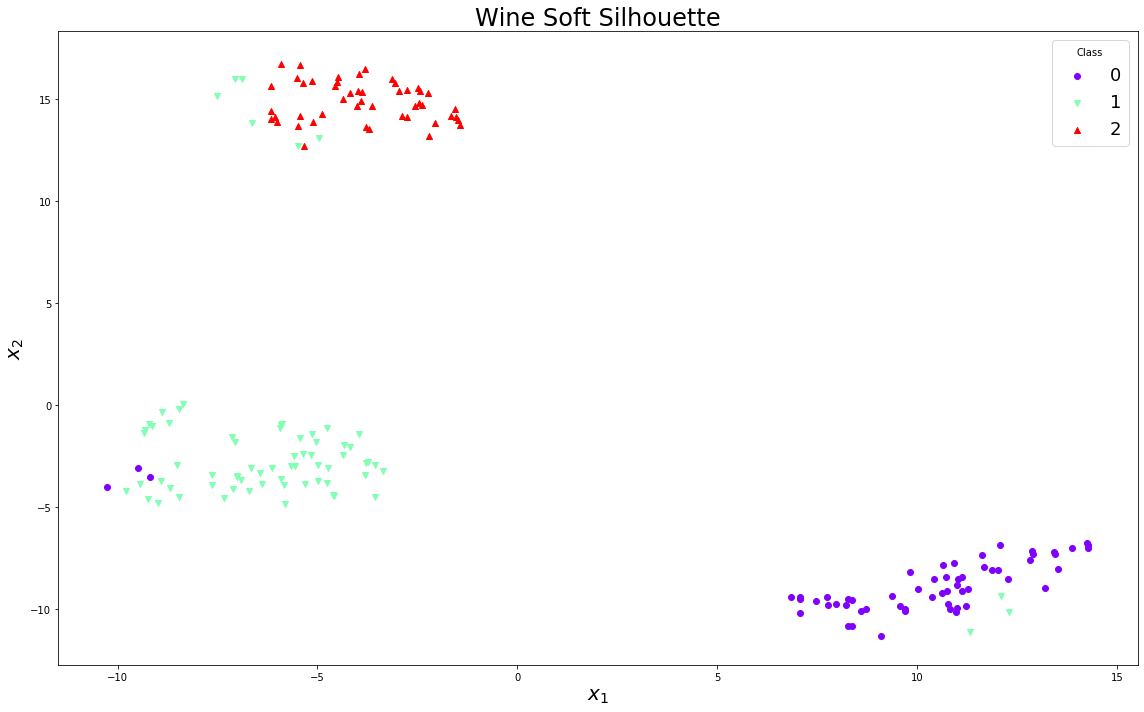

In [7]:
# Cluster with TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_enc = tsne.fit_transform(latent_data)
#tsne_enc = tsne.fit_transform(real_data)

# Color and marker for each true class
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
markers = matplotlib.markers.MarkerStyle.filled_markers

# Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16, 10))
for iclass in range(0, n_clusters):
    # Get indices for each class
    idxs = real_labels==iclass
    # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0], tsne_enc[idxs, 1],
               marker=markers[iclass], c=colors[iclass].reshape(1,-1),
               edgecolor=None, label=r'$%i$'%iclass)
    
figname="Wine Soft Silhouette"
ax.set_title(figname, fontsize=24)
ax.set_xlabel("$x_{1}$", fontsize=20)
ax.set_ylabel("$x_{2}$", fontsize=20)
plt.legend(title="Class", loc='best', numpoints=1, fontsize=18)
plt.tight_layout()
plt.show()
#fig.savefig(figname, facecolor='w')